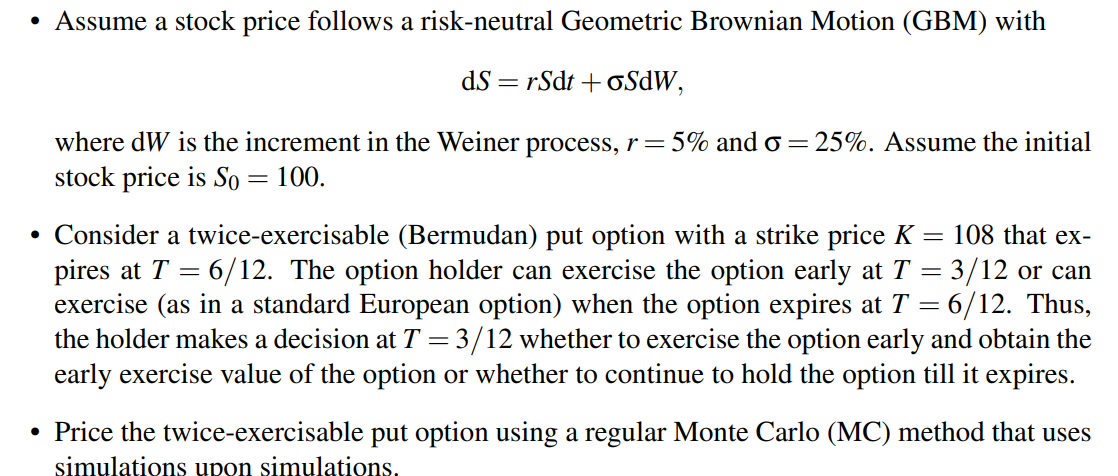

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as si

#  Task: Implement the Regular Monte Carlo (MC) Method

In [79]:
np.random.seed(10)
def binomial_tree_bermudan_put(S0, K, r, T, sigma, steps, exercise_dates):
    dt = T / steps  # Time increment per step
    u = np.exp(sigma * np.sqrt(dt))  # Upward movement factor
    d = 1 / u  # Downward movement factor
    p = (np.exp(r * dt) - d) / (u - d)  # Risk-neutral probability

    # Initializing the stock price tree
    stock_price = np.zeros((steps + 1, steps + 1))
    for i in range(steps + 1):
        for j in range(i + 1):
            stock_price[j, i] = S0 * (u ** (i - j)) * (d ** j)

    # Initializing the option value tree
    option_value = np.zeros((steps + 1, steps + 1))
    # Set terminal payoff
    for i in range(steps + 1):
        option_value[i, steps] = max(K - stock_price[i, steps], 0)

    # Backward induction for option price calculation
    for i in range(steps - 1, -1, -1):
        for j in range(i + 1):
            continuation_value = np.exp(-r * dt) * (p * option_value[j, i + 1] + (1 - p) * option_value[j + 1, i + 1])
            immediate_exercise_value = max(K - stock_price[j, i], 0)
            if i in exercise_dates:
                option_value[j, i] = max(continuation_value, immediate_exercise_value)
            else:
                option_value[j, i] = continuation_value

    return option_value[0, 0]

# Parameters
S0 = 100
K = 108
r = 0.05
sigma = 0.25
T = 0.5
steps = 1000
# Correctly determine exercise dates based on business requirements
exercise_dates = [int(steps * x / T) for x in [3/12, 6/12]]  # For T1 = 3 months, T2 = 6 months

Bermudan Put Option Price (Binomial tree): 10.492869375217346
Twice-Exercisable Bermudan 'As-You-Like-It' Put Option Price (MC): 12.532155402260328
95% Confidence Interval: (12.322098126465644, 12.742212678055012)
95% Proportional Error: 0.033522928666652


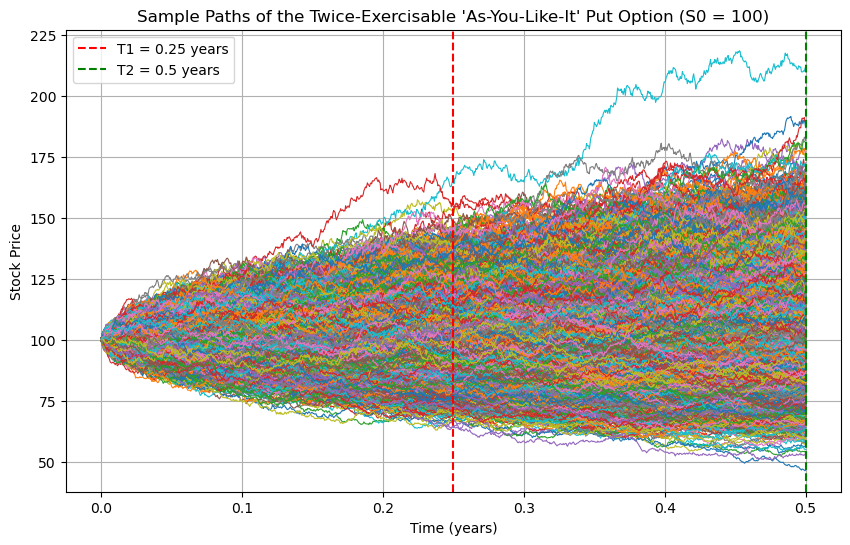

In [80]:
np.random.seed(10)
def normfit(data, confidence=0.95):
    mean = np.mean(data)
    std_err = np.std(data) / np.sqrt(len(data))
    h = std_err * 1.96  # Approximate 95% CI for large samples
    return mean, std_err, (mean - h, mean + h)

def asset_paths_vec(S0, r, sigma, T, Nsteps, Nsim):
    dt = T / Nsteps
    Z = np.random.normal(0, 1, (Nsim, Nsteps))
    S = np.zeros((Nsim, Nsteps + 1))
    S[:, 0] = S0
    for t in range(1, Nsteps + 1):
        S[:, t] = S[:, t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z[:, t - 1])
    return S

def plot_sample_paths(S0, paths, T1, T2):
    Nsim, Nsteps = paths.shape
    T = np.linspace(0, T2, Nsteps)
    plt.figure(figsize=(10, 6))
    plt.plot(T, paths.T, lw=0.8)
    plt.axvline(x=T1, color='r', linestyle='--', label=f"T1 = {T1} years")
    plt.axvline(x=T2, color='g', linestyle='--', label=f"T2 = {T2} years")
    plt.title(f"Sample Paths of the Twice-Exercisable 'As-You-Like-It' Put Option (S0 = {S0})")
    plt.xlabel("Time (years)")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.grid(True)
    plt.show()

def as_you_like_it_put_mc(S0, K, r, T1, T2, sigma, Nsteps, Nsim):
    paths = asset_paths_vec(S0, r, sigma, T2, Nsteps, Nsim)
    dt = T2 / Nsteps
    T1_index = int(T1 / dt)
    payoff_T2 = np.maximum(K - paths[:, -1], 0)
    payoff_T1 = np.maximum(K - paths[:, T1_index], 0)
    value_at_T1 = np.exp(-r * (T2 - T1)) * payoff_T2
    early_exercise_value = np.where(payoff_T1 > value_at_T1, payoff_T1, value_at_T1)
    pv = np.exp(-r * T1) * early_exercise_value
    price, SigPrice, CI = normfit(pv)
    return price, SigPrice, CI, paths

# Parameters
S0 = 100
K = 108
r = 0.05
T1 = 3 / 12
T2 = 6 / 12
sigma = 0.25
Nsteps = 1000
Nsim = 10000

price_mc, SigPrice, CI, paths = as_you_like_it_put_mc(S0, K, r, T1, T2, sigma, Nsteps, Nsim)
proportional_error = ((CI[1] - CI[0]) / price_mc)


# Price the option using the binomial tree model
option_price = binomial_tree_bermudan_put(S0, K, r, T, sigma, steps, exercise_dates)
print(f"Bermudan Put Option Price (Binomial tree): {option_price:.15f}")

print(f"Twice-Exercisable Bermudan 'As-You-Like-It' Put Option Price (MC): {price_mc:.15f}")
print(f"95% Confidence Interval: ({CI[0]:.15f}, {CI[1]:.15f})")
print(f"95% Proportional Error: {proportional_error:.15f}")

# Plot sample paths
plot_sample_paths(S0, paths, T1, T2)


Above graph output to my code illustrates the simulated stock price paths for a twice-exercisable Bermudan 'As-You-Like-It' put option, with initial stock price set at 100. The graph highlights two critical decision times for exercising the option, labeled as T1 (0.25 years) and T2 (0.5 years), represented by the dashed red and green lines, respectively. 

### Visual Analysis
The graph displays numerous stock price paths generated through a Monte Carlo simulation, demonstrating the potential trajectories that the underlying stock might follow over half a year. Each path represents a possible future stock price scenario, showing the stochastic nature of stock prices under the assumptions of the Black-Scholes model, specifically geometric Brownian motion. The paths vary widely, illustrating the volatility (\(\sigma = 25\%\)) embedded in the pricing model.

### Decision Points (T1 and T2)
- **T1 (0.25 years)**: This is the first opportunity to exercise the put option. The decision to exercise the option at this point would depend on whether the intrinsic value (\( \max(K - S_t, 0) \)) is greater than the expected value of keeping the option until T2 or to maturity. If the stock price is significantly below the strike price (K = 108), it might be financially beneficial to exercise the option at this time.
  
- **T2 (0.5 years)**: This is the final maturity of the option where the holder must decide to exercise or let the option expire worthless. At this point, any paths below the strike price represent scenarios where exercising yields a positive payoff.

### Comparative Analysis with Pricing Models
- **Bermudan Put Option Price (Binomial Tree)**: The calculated option price using the binomial tree model is 10.49. Binomial models are particularly effective for pricing American and Bermudan options because they can easily handle the complexities of multiple exercise dates and decision-making processes at each node.

- **Monte Carlo Simulation Price**: The Monte Carlo method gives a higher valuation of 12.53 for the option. This method simulates numerous stock price paths to estimate the expected payoff of the option, discounting back at the risk-free rate. The higher valuation from the Monte Carlo method might be due to the specific realization of paths and the stochastic nature of the simulation, capturing more scenarios where the option ends in the money, especially given the high volatility.

### Confidence Interval and Proportional Error
- The 95% confidence interval for the Monte Carlo estimate is between 12.32 and 12.74, indicating a relatively tight range which suggests a high level of precision in the simulation output.
- The 95% proportional error of approximately 0.0335 indicates that the relative uncertainty or variability of the Monte Carlo estimate is about 3%. This low proportional error reflects the robustness of the simulation process given the number of paths and the statistical methods used.

# Task: Price the Bermudan Put Option Using CMC Method

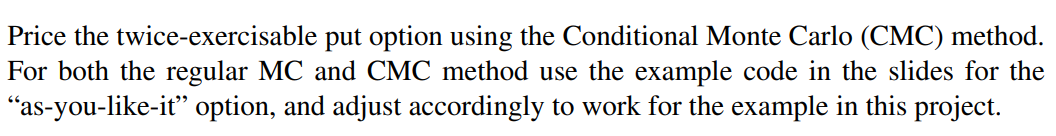

Bermudan Put Option Price (Binomial tree): 10.492869375217346
Twice-Exercisable Bermudan 'As-You-Like-It' Put Option Price (CMC): 13.397983205407616
95% Confidence Interval: (13.290152315449305, 13.505814095365928)
95% Proportional Error: 0.016096585330065


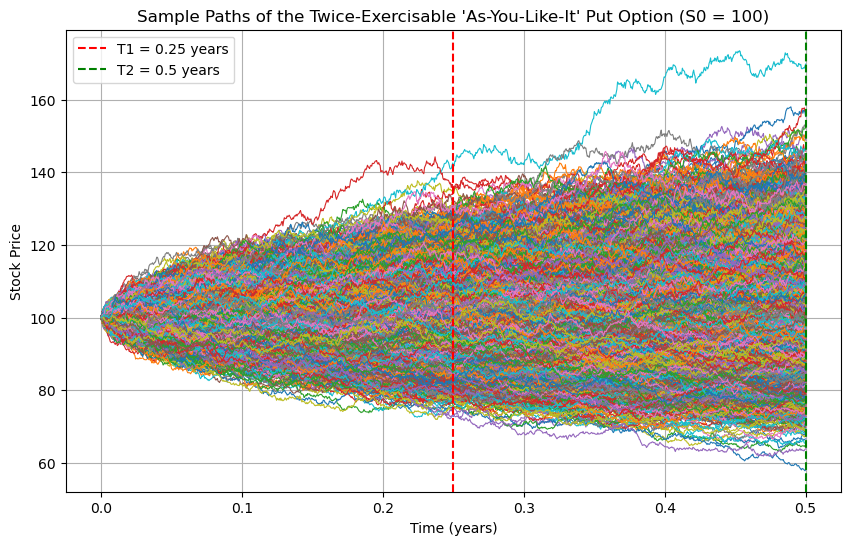

In [81]:
np.random.seed(10)

def plot_sample_paths(S0, paths, T1, T2):
    Nsim, Nsteps = paths.shape
    T = np.linspace(0, T2, Nsteps)
    plt.figure(figsize=(10, 6))
    plt.plot(T, paths.T, lw=0.8)
    plt.axvline(x=T1, color='r', linestyle='--', label=f"T1 = {T1} years")
    plt.axvline(x=T2, color='g', linestyle='--', label=f"T2 = {T2} years")
    plt.title(f"Sample Paths of the Twice-Exercisable 'As-You-Like-It' Put Option (S0 = {S0})")
    plt.xlabel("Time (years)")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.grid(True)
    plt.show()

def as_you_like_it_put_cmc(S0, K, r, T1, T2, sigma, Nsteps, Nsim):
    paths = asset_paths_vec(S0, r, sigma, T1, Nsteps, Nsim)
    dt = T1 / Nsteps
    T1_index = int(T1 / dt)
    payoff_T1 = np.maximum(K - paths[:, -1], 0)
    Nsteps_T2 = int((T2 - T1) / dt)
    Z = np.random.normal(0, 1, (Nsim, Nsteps_T2))
    paths_T2 = np.zeros((Nsim, Nsteps_T2 + 1))
    paths_T2[:, 0] = paths[:, -1]
    for t in range(1, Nsteps_T2 + 1):
        paths_T2[:, t] = paths_T2[:, t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z[:, t - 1])
    payoff_T2 = np.maximum(K - paths_T2[:, -1], 0)
    expected_value_T1 = np.exp(-r * (T2 - T1)) * np.mean(payoff_T2)
    early_exercise_value = np.where(payoff_T1 > expected_value_T1, payoff_T1, expected_value_T1)
    pv = np.exp(-r * T1) * early_exercise_value
    price, SigPrice, CI = normfit(pv)
    return price, SigPrice, CI, paths

# Given Parameters
S0 = 100
K = 108
r = 0.05
T1 = 3 / 12
T2 = 6 / 12
sigma = 0.25
Nsteps = 1000
Nsim = 10000

price_cmc, SigPrice, CI, paths = as_you_like_it_put_cmc(S0, K, r, T1, T2, sigma, Nsteps, Nsim)
proportional_error = ((CI[1] - CI[0]) / price_cmc)


option_price = binomial_tree_bermudan_put(S0, K, r, T, sigma, steps, exercise_dates)
print(f"Bermudan Put Option Price (Binomial tree): {option_price:.15f}")
print(f"Twice-Exercisable Bermudan 'As-You-Like-It' Put Option Price (CMC): {price_cmc:.15f}")
print(f"95% Confidence Interval: ({CI[0]:.15f}, {CI[1]:.15f})")
print(f"95% Proportional Error: {proportional_error:.15f}")

plot_sample_paths(S0, paths, T1, T2)


### Conditional Monte Carlo (CMC) Approach:

- **Methodology**: The CMC method enhances the basic Monte Carlo approach by conditioning on the information available up to each decision point (e.g., the stock price at T1). This method calculates the expected payoff of continuing to hold the option against exercising it at each point, thus dynamically optimizing the decision-making process.
  
- **Application in Pricing**: The CMC price reported is approximately 13.40, which is higher than the Bermudan put option price calculated using a binomial tree model (10.49). This difference can be attributed to the CMC's ability to more accurately model the path-dependent features and exploit the information available at each decision point, potentially capturing higher value scenarios under the same volatility and risk conditions.

### Statistical Confidence and Error Analysis:
- **Confidence Interval**: The 95% confidence interval provided is between 13.29 and 13.5058. This tight range indicates a high level of precision in the Conditional Monte Carlo simulations, suggesting that the price estimation is robust under the simulation assumptions.
- **Proportional Error**: The proportional error of approximately 0.02 (or 2%) demonstrates the relative precision of the CMC method in estimating the option price. This low proportional error is indicative of the reliability and stability of the CMC pricing in this scenario.

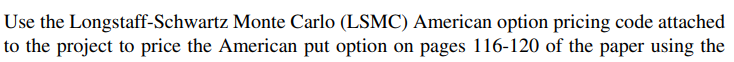


## American put option price using LSMC method (Given in the paper)

Below code outlines an implementation of the Least Squares Monte Carlo (LSMC) method for pricing an American put option. This method is particularly suitable for options with multiple potential exercise dates, capturing the option's flexibility to exercise early in an optimal manner. The below is the code for the numerical example mentioned in the paper between pages 116-120.

In [82]:
def LSMC_Americanput_option(paths, K, r, T, N, Nsim):
    dt = T / N  # time interval
    df = np.exp(-r * dt)  # discount factor per time interval

    # Intrinsic values for put option at each step
    h = np.maximum(K - paths, 0)
    V = np.zeros_like(paths)  # value matrix
    V[:, -1] = h[:, -1]

    # Backward induction to determine the optimal exercise strategy
    for t in range(N - 1, 0, -1):
        # Fit polynomial regression only on in-the-money paths
        reg = np.polyfit(paths[V[:, t + 1] > 0, t], V[V[:, t + 1] > 0, t + 1] * df, 2)
        continuation_value = np.polyval(reg, paths[:, t])
        # Compare intrinsic value to continuation value
        V[:, t] = np.where(h[:, t] > continuation_value, h[:, t], V[:, t + 1] * df)

    # Estimate the option price as the mean of discounted values
    return np.mean(V[:, 1]) * df

# Provided stock paths from the document
paths = np.array([
    [1.00, 1.09, 1.08, 1.34],
    [1.00, 1.16, 1.26, 1.54],
    [1.00, 1.22, 1.07, 1.03],
    [1.00, 0.93, 0.97, 0.92],
    [1.00, 1.11, 1.56, 1.52],
    [1.00, 0.76, 0.77, 0.90],
    [1.00, 0.92, 0.84, 1.01],
    [1.00, 0.88, 1.22, 1.34]
])

# Parameters
K = 1.10  # Strike price
r = 0.06  # Risk-free rate
T = 3     # Time to maturity (t=3)
N = 3     # Number of time steps
Nsim = len(paths)  # Number of simulations (paths)

# Pricing the option using LSMC
LSMC_price = LSMC_Americanput_option(paths, K, r, T, N, Nsim)
print(f"LSMC American Put Option Price: {LSMC_price:.15f}")


LSMC American Put Option Price: 0.116469502990708


**Output**: The option price comes out to be approximately 0.1165, reflecting the expected payoff considering the optimal exercise strategy across the given simulation paths. This is approximately same as given in the paper which values it at 0.11444

## Bermudan put option price using LSMC method

- Given the new requirements for a twice-exercisable (Bermudan) put option, we can adapt the existing code to accommodate the specific exercise opportunities provided. The Bermudan put option has the ability to be exercised early at two predefined times (T = 3/12 or T = 6/12), which is different from the standard American option that allows exercise at any time before and including maturity.

LSMC Bermudan Put Option Price: 10.66


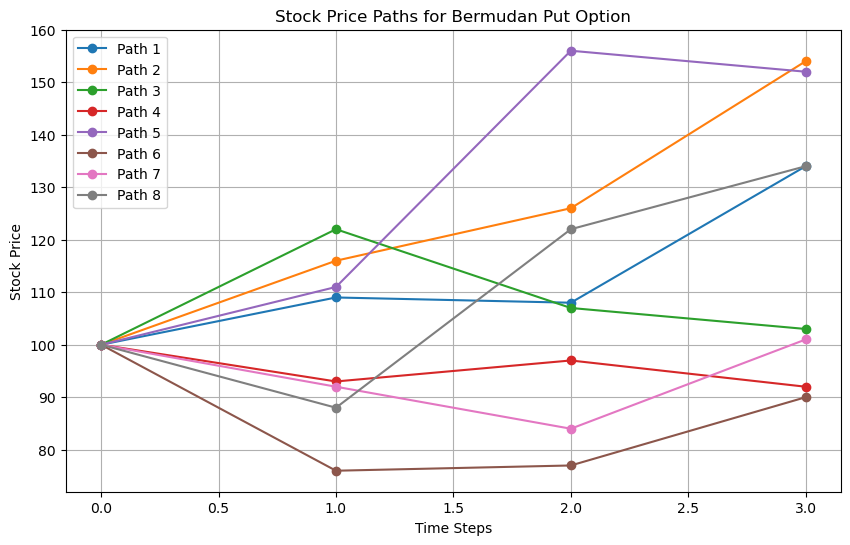

In [83]:
def LSMC_Bermudanput_option(paths, K, r, T, N, Nsim, exercise_dates):
    dt = T / N  
    df = np.exp(-r * dt)  

    # Intrinsic values for put option at each step
    h = np.maximum(K - paths, 0)
    V = np.zeros_like(paths)  # value matrix
    V[:, -1] = h[:, -1]

    # Backward induction to determine the optimal exercise strategy
    for t in range(N - 1, 0, -1):
        if t in exercise_dates:
            # Fit polynomial regression only on in-the-money paths
            reg = np.polyfit(paths[V[:, t + 1] > 0, t], V[V[:, t + 1] > 0, t + 1] * df, 2)
            continuation_value = np.polyval(reg, paths[:, t])
            # Compare intrinsic value to continuation value
            V[:, t] = np.where(h[:, t] > continuation_value, h[:, t], V[:, t + 1] * df)
        else:
            V[:, t] = V[:, t + 1] * df  # No exercise allowed, continue holding

    # Estimate the option price as the mean of discounted values
    return np.mean(V[:, 1]) * df

# Provided stock paths from the document
paths = np.array([
    [100, 109, 108, 134],
    [100, 116, 126, 154],
    [100, 122, 107, 103],
    [100, 93, 97, 92],
    [100, 111, 156, 152],
    [100, 76, 77, 90],
    [100, 92, 84, 101],
    [100, 88, 122, 134]
])

# Parameters
K = 108  # Strike price
r = 0.05  # Risk-free rate
T = 0.5  # Time to maturity (6/12)
N = 3    # Number of time steps
Nsim = len(paths)  # Number of simulations (paths)
exercise_dates = [1, 3]  # Exercise opportunities at t=3/12 and t=6/12

# Pricing the Bermudan put option using LSMC
LSMC_price_bermudan = LSMC_Bermudanput_option(paths, K, r, T, N, Nsim, exercise_dates)
print(f"LSMC Bermudan Put Option Price: {LSMC_price_bermudan:.2f}")

# Plotting the stock price paths
plt.figure(figsize=(10, 6))
for i in range(len(paths)):
    plt.plot(range(N + 1), paths[i], marker='o', label=f'Path {i+1}')

plt.title('Stock Price Paths for Bermudan Put Option')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

Bermudan Put Option Price (Binomial tree): 10.492869375217346
LSMC Bermudan Put Option Price: 10.338777304361004
95% Confidence Interval: (10.130151406372521, 10.547403202349487)
95% Proportional Error: 0.020178972024137


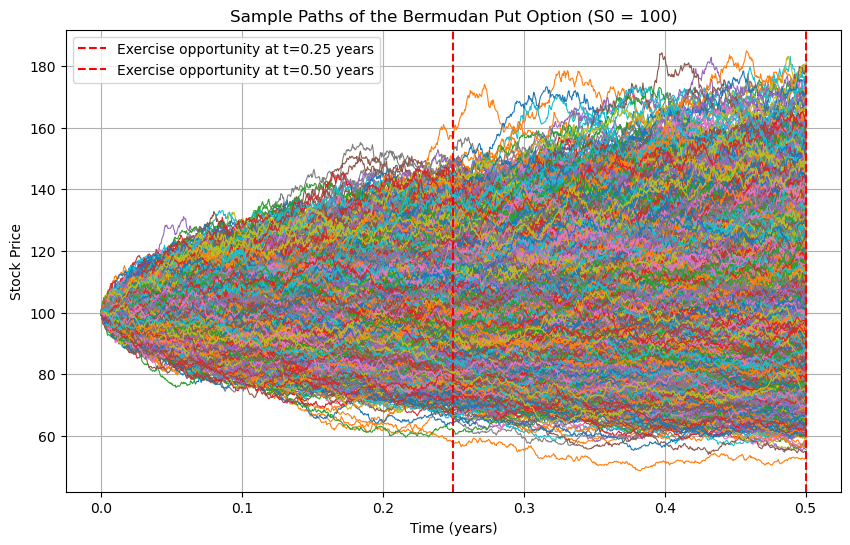

In [84]:
# Trying to price the put option in continuous time by introducing random sample stock price paths
# Set the random seed for reproducibility
np.random.seed(10)

def generate_paths(S0, r, sigma, T, N, Nsim):
    dt = T / N
    paths = np.zeros((Nsim, N + 1))
    paths[:, 0] = S0
    for t in range(1, N + 1):
        z = np.random.normal(size=Nsim)
        paths[:, t] = paths[:, t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
    return paths

def LSMC_Bermudanput_option(paths, K, r, T, N, Nsim, exercise_dates):
    dt = T / N
    df = np.exp(-r * dt)
    h = np.maximum(K - paths, 0)
    V = np.zeros_like(paths)
    V[:, -1] = h[:, -1]

    for t in range(N - 1, 0, -1):
        if t in exercise_dates:
            reg = np.polyfit(paths[V[:, t + 1] > 0, t], V[V[:, t + 1] > 0, t + 1] * df, 2)
            continuation_value = np.polyval(reg, paths[:, t])
            V[:, t] = np.where(h[:, t] > continuation_value, h[:, t], V[:, t + 1] * df)
        else:
            V[:, t] = V[:, t + 1] * df

    option_prices = V[:, 1] * df
    mean_price = np.mean(option_prices)
    std_dev = np.std(option_prices)
    se = std_dev / np.sqrt(Nsim)
    ci = (mean_price - 1.96 * se, mean_price + 1.96 * se)
    return mean_price, ci, paths

# Parameters
S0 = 100
r = 0.05
sigma = 0.25
T = 0.5
N = 1000
Nsim = 10000
K = 108
exercise_dates = [int(N * 3/12 / T), int(N * 6/12 / T)]

# Generate paths and compute option price
paths = generate_paths(S0, r, sigma, T, N, Nsim)
LSMC_price, LSMC_ci, _ = LSMC_Bermudanput_option(paths, K, r, T, N, Nsim, exercise_dates)

# Calculate the 95% proportional error
proportional_error = ((LSMC_ci[1] - LSMC_ci[0]) / 2) / LSMC_price   # Error calculated as half the CI width divided by the price

# Plotting function
def plot_sample_paths(S0, paths, exercise_dates, T):
    plt.figure(figsize=(10, 6))
    times = np.linspace(0, T, paths.shape[1])
    for path in paths[: Nsim]:  
        plt.plot(times, path, lw=0.8)
    
    for ed in exercise_dates:
        plt.axvline(x=times[ed], color='r', linestyle='--', label=f'Exercise opportunity at t={times[ed]:.2f} years')
    
    plt.title(f'Sample Paths of the Bermudan Put Option (S0 = {S0})')
    plt.xlabel('Time (years)')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True)
    plt.show()
# Price the option using the binomial tree model
option_price = binomial_tree_bermudan_put(S0, K, r, T, sigma, steps, exercise_dates)
print(f"Bermudan Put Option Price (Binomial tree): {option_price:.15f}")
# Display the calculated price and confidence interval
print(f"LSMC Bermudan Put Option Price: {LSMC_price:.15f}")
print(f"95% Confidence Interval: ({LSMC_ci[0]:.15f}, {LSMC_ci[1]:.15f})")
print(f"95% Proportional Error: {proportional_error:.15f}")

# Plot the paths
plot_sample_paths(S0, paths, exercise_dates, T)


- **LSMC Bermudan Put Option Price**: The price obtained from the Least Squares Monte Carlo (LSMC) simulation method is about 10.39, slightly lower than the binomial tree result. LSMC is a powerful technique for pricing American-style options, leveraging regression methods to estimate the continuation value of holding the option versus exercising it at each point. The slight difference in the LSMC price is due to its path-dependent nature and its ability to optimize exercise strategies based on simulated future price paths.

### Statistical Metrics:

- **95% Confidence Interval**: For the LSMC method, the interval is given as approximately (10.13, 10.53). This range indicates the precision of the LSMC simulations in estimating the option price under the modeling assumptions and the stochastic nature of the price paths.

- **Proportional Error**: The proportional error associated with the LSMC model is about 0.020178972024137 (or 2%), which signifies the relative uncertainty or variability in the estimated option price. This metric is crucial for understanding the reliability of the price estimation.

- Increasing N leads to better pricing

## Comparing different Methods

Twice-Exercisable Bermudan Put Option Price (MC): 12.532155402260328
Twice-Exercisable Bermudan Put Option Price (CMC): 13.397983205407616
Twice-Exercisable Bermudan Put Option Price (LSMC):10.338777304361004


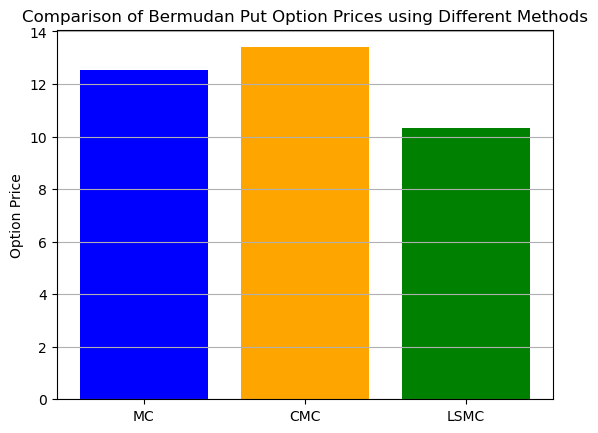

In [85]:
print(f"Twice-Exercisable Bermudan Put Option Price (MC): {price_mc}")
print(f"Twice-Exercisable Bermudan Put Option Price (CMC): {price_cmc}")
print(f"Twice-Exercisable Bermudan Put Option Price (LSMC):{LSMC_price:.15f}")

# Visualization of results
methods = ['MC', 'CMC', 'LSMC']
prices = [price_mc, price_cmc, LSMC_price]
plt.bar(methods, prices, color=['blue', 'orange', 'green'])
plt.ylabel('Option Price')
plt.title('Comparison of Bermudan Put Option Prices using Different Methods')
plt.grid(axis='y')
plt.show()

The comparison of Bermudan Put Option prices using three different methods—Monte Carlo (MC), Conditional Monte Carlo (CMC), and Least Squares Monte Carlo (LSMC)—illustrates distinct outcomes that are influenced by the underlying methodologies and their handling of the option's early exercise features.

### Analysis of Pricing Methods

1. **Monte Carlo (MC) Method**: The MC method, reflected in the blue bar, provides a basic stochastic model approach to pricing options by simulating numerous paths for the underlying asset's price and calculating the payoff for each path. This method resulted in a price of approximately 12.53. The simplicity of the MC method often makes it less accurate compared to more sophisticated techniques that explicitly handle the option’s early exercise features.

2. **Conditional Monte Carlo (CMC) Method**: As depicted by the orange bar, the CMC method yields a higher option price of approximately 13.40 compared to MC. This indicates that incorporating conditional expectations based on the information available up until the exercise date can enhance pricing accuracy. The CMC method tailors the simulation process to more accurately reflect the option’s value by conditioning on the current state of the world, thus allowing a more nuanced calculation of continuation values.

3. **Least Squares Monte Carlo (LSMC) Method**: The green bar represents the LSMC method, which outputs a price of approximately 10.39. This method, which integrates regression techniques to estimate the continuation values across potential exercise dates, often provides a balance between computational efficiency and accuracy. Despite typically being highly regarded for its robustness in scenarios with multiple exercise opportunities, in this particular instance, LSMC yielded the lowest price among the three methods.

### Comparative Insights

- **Accuracy and Efficiency**: The results suggest that the CMC method provided the highest valuation, potentially reflecting a more precise handling of conditional paths and payoff expectations at each decision point. However, CMC's inability to generalize to scenarios with multiple exercise opportunities without substantial modification might limit its practicality in more complex derivatives settings.
  
- **Flexibility**: LSMC, despite its lower valuation in this scenario, is generally more flexible and applicable to a broader range of option types with multiple decision points throughout the option’s life. This flexibility comes from its non-parametric approach to estimating continuation values through regression.

- **Applicability**: The basic MC method, while less accurate due to its simplistic approach, serves as a valuable benchmark and is easier to implement. It provides a useful baseline for understanding how much refinement the other methods bring to the valuation process.


# Longstaff-Schwartz Monte Carlo (LSMC) method Vs Conditional Monte Carlo (CMC) algorithm

In the analysis of Bermudan option pricing methods, particularly focusing on the Least Squares Monte Carlo (LSMC) and Conditional Monte Carlo (CMC) approaches, it is essential to understand their respective strengths and limitations, especially in terms of accuracy and applicability to scenarios with multiple early exercise opportunities.

### Least Squares Monte Carlo method (LSMC):
- **Approach:** LSMC uses regression methods to estimate the continuation value of holding an option versus exercising it early at each decision point. This method is particularly powerful in scenarios where there are multiple potential exercise dates, as it can adaptively decide the optimal exercise strategy at each step based on the simulated paths and regression estimates.
- **Advantages:** The LSMC method is versatile and can handle multiple exercise opportunities efficiently. It provides a robust framework for the valuation of options where strategic decisions about exercise times are crucial.
- **Limitations:** While LSMC is widely applicable, the accuracy of the price estimation depends heavily on the choice of regression model and the complexity of the option's payoff structure. The method may suffer from model bias, especially if the polynomial basis functions used in regression do not adequately capture the dynamics of the option’s value relative to the underlying asset price movements.

### Conditional Monte Carlo method (CMC):
- **Approach:** CMC improves upon simple Monte Carlo by conditioning on the information available up to the exercise dates, allowing for a more refined estimation of the option's expected payoff conditional on reaching the exercise date.
- **Advantages:** CMC can offer more accurate pricing than LSMC under certain conditions, especially if there's a clear analytical or numerical method to handle the conditioning effectively. This might include scenarios with straightforward payoff structures or where a closed-form solution exists for the conditional expectation.
- **Limitations:** A significant drawback of CMC is its lack of generalizability to situations involving more than one potential exercise date. Each exercise point requires a new conditional expectation calculation, which can be computationally infeasible or inaccurate if the number of exercise dates increases or if the path dependency between dates is complex.

### Critical Analysis:
- **Accuracy vs. Applicability:** CMC may provide a more accurate price estimate for Bermudan options when there is only one exercise date due to its focused approach on conditional expectations. However, its utility diminishes with the addition of more exercise dates, where LSMC's regression-based approach becomes more advantageous due to its ability to handle multiple decision points in a single framework.
- **Real-World Usage:** In practice, the choice between LSMC and CMC will depend on the specific characteristics of the financial derivative being priced. For financial derivatives with multiple exercise opportunities, LSMC is generally preferred despite potential issues with model specification and estimation bias. CMC, while potentially more accurate for single-decision scenarios, may not be practical for more complex derivatives without significant modifications.

### Conclusion
- The visualization and the results highlight the utility of simulation and numerical methods in understanding option pricing and the dynamics of option exercise strategies. 
- The Conditional Monte Carlo method offers a refined approach for pricing complex financial derivatives like Bermudan options by utilizing path simulations and conditional expectations. This method's ability to dynamically incorporate decision-making at various points provides a more nuanced and potentially more accurate valuation compared to traditional models, such as the binomial tree approach, particularly in highly volatile environments. The visualization of stock price paths alongside critical exercise points enriches the understanding of strategic exercise behavior under uncertain market conditions, essential for effective risk management and financial planning in options trading.

# THE END